Updates:

The stacking model:
https://www.kaggle.com/schoolpal/nn-stacking-magic-no-magic-30409-private-31063

https://www.kaggle.com/schoolpal/modifications-to-reynaldo-s-script/notebook
I just added two XGB models, they were used together with in this one and one more DNN model in the stacking

--------------------------------------------------------

This is a simple LightGBM script. It got two magic number, one took from Andy's script (proposed by Louis?). The second one actually down scale only the "old" investment properties, as the new ones are supported by the mortgage subsidy program? The LB score is at 0.3094. 


One nice thing is that the classical BoxCox transformation can further improve the performance to 0.3093. It can also be verified by local skewness.  I wonder why no one bring this up in the kernel/forum.

This script (log version) serves as one of the basis model for the later stacking.

In [1]:
# !pip install lightgbm

In [2]:
from sklearn.model_selection import train_test_split,KFold,TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from sklearn import model_selection, preprocessing
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn import model_selection, preprocessing
import pdb

In [3]:
# LGBM model parameters
RS=1     # random seed               
np.random.seed(RS)
ROUNDS = 1500 # 1300,1400 all works fine. 
params = {
    'objective': 'regression',
        'metric': 'rmse',
        'boosting': 'gbdt',
        'learning_rate': 0.01 , #small learn rate, large number of iterations
        'verbose': -1,
        'num_leaves': 2 ** 5,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': RS,
        'feature_fraction': 0.7,
        'feature_fraction_seed': RS,
        'max_bin': 100,
        'max_depth': 7,
        'num_rounds': ROUNDS,
    }

def single_model(x_train, x_test, y_train):
    x_train = x_train.drop(['timestamp','id'],axis=1)
    x_test = x_test.drop(['timestamp','id'],axis=1)
    y_train=np.log(y_train)
    
    # creating the lgb dataset and training model
    train_lgb = lgb.Dataset(x_train,y_train)
    model=lgb.train(params,train_lgb,num_boost_round=ROUNDS)
    
    # test model
    predict=model.predict(x_test)
    predict=np.exp(predict)
    return model, predict

def get_validation_rmsle(x_train, y_train, split= True):
    seed = 42      # random number to serve as seed for reproducibility
    if not split:
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=seed)
        _, output = single_model(x_train, x_test, y_train) 
    else:
        x_train_inv = x_train['x_train_inv']
        x_train_other = x_train['x_train_other']
        y_train_inv = y_train['y_train_inv']
        y_train_other = y_train['y_train_other']
        
        x_train_inv, x_test_inv, y_train_inv, y_test_inv = train_test_split(
            x_train_inv, 
            y_train_inv,
            test_size=0.33, random_state=seed)
        
        x_train_other, x_test_other, y_train_other, y_test_other = train_test_split(
            x_train_other,
            y_train_other, 
            test_size=0.33, random_state=seed)
        
        y_test_inv = pd.DataFrame({"id":x_test_inv['id'], "price_doc":y_test_inv})
        y_test_other = pd.DataFrame({"id":x_test_other['id'], "price_doc":y_test_other})
        y_test = pd.concat([y_test_inv, y_test_other], sort=False)
        y_test = y_test.sort_values(by=['id'])
        
        output,_,_ = split_model(x_train_inv, x_test_inv, x_train_other, x_test_other, y_train_inv, y_train_other)
        output = output['price_doc'].to_numpy(np.float64)
        y_test = y_test['price_doc']
    
    rmsle = mean_squared_log_error(y_test.to_numpy(np.float64), output, squared=False)
    print("rmsle: ", rmsle)    
    
def split_model(x_train_inv, x_test_inv, x_train_other, x_test_other, y_train_inv, y_train_other):
    
    x_test_inv_id = x_test_inv['id']
    x_test_other_id = x_test_other['id']
    
    # REMOVING UNNECESSARY COLUMNS
    x_train_inv = x_train_inv.drop(['timestamp','id'],axis=1)
    x_train_other = x_train_other.drop(['timestamp','id'],axis=1)
    x_test_inv = x_test_inv.drop(['timestamp','id'],axis=1)
    x_test_other = x_test_other.drop(['timestamp','id'],axis=1)
    
    
    #Log transformation, boxcox works better. What is this for?
    # y_train=np.log(y_train)
    y_train_inv = np.log(y_train_inv)
    y_train_other = np.log(y_train_other)
    
    
    # Train different lgb models based on investment or non-investment
    inv_train_lgb = lgb.Dataset(x_train_inv,y_train_inv)
    other_train_lgb = lgb.Dataset(x_train_other,y_train_other)
    
    inv_model=lgb.train(params,inv_train_lgb,num_boost_round=ROUNDS)
    other_model=lgb.train(params,other_train_lgb,num_boost_round=ROUNDS)
    
    # Predict and get results
    inv_predict = inv_model.predict(x_test_inv)
    inv_predict = np.exp(inv_predict)
    other_predict = other_model.predict(x_test_other)
    other_predict = np.exp(other_predict)
    
    
    # Merge predictions
    inv_output = pd.DataFrame({'id':x_test_inv_id,'price_doc':inv_predict})
    other_output = pd.DataFrame({'id':x_test_other_id,'price_doc':other_predict})
    output = pd.concat([inv_output, other_output], sort=False)
    output = output.sort_values(by=['id'])
    return output, inv_model ,other_model

In [4]:
train = pd.read_csv('/kaggle/input/russian-sberbank/train.csv',parse_dates=['timestamp'])
test = pd.read_csv('/kaggle/input/russian-sberbank/test.csv',parse_dates=['timestamp'])

### remove erroneous datapoints and replace with appropriate figures
For test

In [5]:


# Seasonal Component
test['month'] = test['timestamp'].dt.month

#There are 381 observations where floor is greater than max_floor
sub_area_floor_median = test.groupby('sub_area')['floor'].median().round().astype(int)
test.loc[test['floor'] > test['max_floor']]['floor'] = np.nan
test['floor'] = test['floor'].fillna(test['sub_area'].map(sub_area_floor_median))

/tmp/ipykernel_20/2457175097.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[test['floor'] > test['max_floor']]['floor'] = np.nan


For train

In [6]:
# state should be discrete valued between 1 and 4. data entry error
train['state'] = train['state'].replace(33, train['state'].mode()[0])

# build_year has an erroneous value 20052009.replace it with 2007
train['build_year'] = train['build_year'].replace(20052009, 2007)

# Seasonal Component
train['month'] = train['timestamp'].dt.month

#There are 381 observations where floor is greater than max_floor. Replace with the median floor in thr sub_area
sub_area_floor_median = train.groupby('sub_area')['floor'].median().round().astype(int)
train.loc[train['floor'] > train['max_floor']]['floor'] = np.nan
train['floor'] = train['floor'].fillna(train['sub_area'].map(sub_area_floor_median))

/tmp/ipykernel_20/2619869187.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[train['floor'] > train['max_floor']]['floor'] = np.nan


### Replace NaN build year with median build year
For test

In [7]:
# copy the the num room with the closest full_sq  for any num room with na values using interpolation
test_sorted = test.sort_values(by='full_sq')
test['num_room'] = test_sorted['num_room'].interpolate(method='linear', limit_direction='both').round().astype(int)

# Nonsensical years Replace with Nan
test.iloc[((test['build_year']<=1691) | (test['build_year']>=2018)).values]['build_year'] = np.nan
#find the build year for the same sub_area and replace na values for build_year
sub_area_build_year_median = test.groupby('sub_area')['build_year'].median().round().astype(int)
test['build_year'] = test['build_year'].fillna(test['sub_area'].map(sub_area_build_year_median))

# get the full_sq mean for datapoint according to num_room,build_year,floor,sub_area
mean_full_sq = test.groupby(['num_room','build_year','floor','sub_area'], as_index=True)["full_sq"].mean()
test = pd.merge(test, mean_full_sq, on=['num_room', 'build_year', 'floor', 'sub_area'], how='left', suffixes=('', '_mean'))
test['normalised_full_sq'] = test['full_sq']/test['full_sq_mean']
# test = test.drop(columns=['full_sq'])

/tmp/ipykernel_20/1378684654.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.iloc[((test['build_year']<=1691) | (test['build_year']>=2018)).values]['build_year'] = np.nan


For train

In [8]:
# copy the the num room with the closest full_sq  for any num room with na values using interpolation
train_sorted = train.sort_values(by='full_sq')
train['num_room'] = train_sorted['num_room'].interpolate(method='linear', limit_direction='both').round().astype(int)

# Nonsensical years Replace with Nan
train.iloc[((train['build_year']<=1691) | (train['build_year']>=2018)).values]['build_year'] = np.nan
#find the build year for the same sub_area and replace na values for build_year
sub_area_build_year_median = train.groupby('sub_area')['build_year'].median().round().astype(int)
train['build_year'] = train['build_year'].fillna(train['sub_area'].map(sub_area_build_year_median))

# get the full_sq mean for datapoint according to num_room,build_year,floor,sub_area
mean_full_sq = train.groupby(['num_room','build_year','floor','sub_area'], as_index=True)["full_sq"].mean()
train = pd.merge(train, mean_full_sq, on=['num_room', 'build_year', 'floor', 'sub_area'], how='left', suffixes=('', '_mean'))
train['normalised_full_sq'] = train['full_sq']/train['full_sq_mean']
# train = train.drop(columns=['full_sq'])

/tmp/ipykernel_20/1572873748.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.iloc[((train['build_year']<=1691) | (train['build_year']>=2018)).values]['build_year'] = np.nan


In [9]:
id_test = test.id       # ids of test data 

train['density'] = train['raion_popul'] / (train['area_m'] / 1000000)

#Remove the bad prices as suggested by Radar, only for TRAIN
train=train[(train.price_doc>1e6) & (train.price_doc!=2e6) & (train.price_doc!=3e6)]
train.loc[(train.product_type=='Investment') & (train.build_year<2000),'price_doc']*=0.9 
train.loc[train.product_type!='Investment','price_doc']*=0.969 #Louis/Andy's magic number

#Identify rows that belong to investment and non-investment properties
# Get the price of those properties
inv_properties = train.loc[train.product_type == 'Investment']
other_properties = train.loc[train.product_type != 'Investment']
y_train_inv = inv_properties["price_doc"]
y_train_other = other_properties["price_doc"]

In [10]:
num_train = train.shape[0]      # number of train data
y_train = train["price_doc"]
train.drop(['price_doc'],inplace=True,axis=1)  
# merge train and test to prepare for deletion of useless columns
da=pd.concat([train,test])

In [11]:
# Check if you are using the original code here to remove columns
original_column_remove_flag = False
# Filter out categorical data to find columns with rare features
df_cat=None
to_remove=[]
for c in da.columns:
    if da[c].dtype=='object':    # if column is categorical        

        # find out which cells have None value for this column
        oh=pd.get_dummies(da[c],prefix=c)   

        # Add the dummies dataframe df_cat
        if df_cat is None:
            df_cat=oh
        else:
            df_cat=pd.concat([df_cat,oh],axis=1)

        to_remove.append(c)

da.drop(to_remove,inplace=True,axis=1)

In [12]:
#Remove rare features,prevent overfitting
to_remove=[]
if df_cat is not None:

    # find out how many proper values each column has
    sums=df_cat.sum(axis=0)

    # mark columns that have too little proper values (not None)
    to_remove=sums[sums<200].index.values

    # remove from our categorical dataframe
    df_cat=df_cat.loc[:,df_cat.columns.difference(to_remove)]

    # add back the categorical columns to our original dataframe
    da = pd.concat([da, df_cat], axis=1)
    original_column_remove_flag = True

x_train=da[:num_train]
x_test=da[num_train:]

In [13]:
if original_column_remove_flag:
    x_train_inv = x_train.loc[x_train.product_type_Investment == True]
    x_train_other = x_train.loc[x_train.product_type_Investment != True]

    x_test_inv = x_test.loc[x_test.product_type_Investment == True]
    x_test_other = x_test.loc[x_test.product_type_Investment != True]

else:      
    x_train_inv = x_train.loc[x_train['product_type'] == 'Investment']
    x_train_other = x_train.loc[x_train['product_type'] != 'Investment']

    x_test_inv = x_test.loc[x_test['product_type'] == 'Investment']
    x_test_other = x_test.loc[x_test['product_type'] != 'Investment']

In [14]:
0.2408036832862386

0.2408036832862386

In [15]:
get_validation_rmsle({'x_train_inv':x_train_inv, 'x_train_other':x_train_other},{'y_train_inv':y_train_inv, 'y_train_other':y_train_other})
output, inv_model, other_model = split_model(x_train_inv, x_test_inv, x_train_other, x_test_other, y_train_inv, y_train_other)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


rmsle:  0.2408616343718961


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [16]:
get_validation_rmsle(x_train, y_train, split=False)
%time model, predict = single_model(x_train, x_test, y_train)
output1 = pd.DataFrame({'id':id_test,'price_doc':predict})

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


rmsle:  0.25070674506969837


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 2min 7s, sys: 8.47 s, total: 2min 16s
Wall time: 49.5 s


In [17]:
output.to_csv('submission.csv',index=False)
print("Done")

Done


In [18]:
output

,id,price_doc
0,30474,5.311855e+06
1,30475,8.299165e+06
2,30476,5.284209e+06
3,30477,6.248644e+06
4,30478,4.910806e+06
...,...,...
7657,38131,8.602316e+06
7658,38132,4.825006e+06
7659,38133,4.309385e+06
7660,38134,5.416909e+06


In [19]:
import shap
valid_x = x_test.drop(['timestamp','id'],axis=1)
explainer = shap.TreeExplainer(inv_model)
%time shap_values = explainer.shap_values(valid_x)

CPU times: user 2min 34s, sys: 14.3 ms, total: 2min 34s
Wall time: 40.6 s


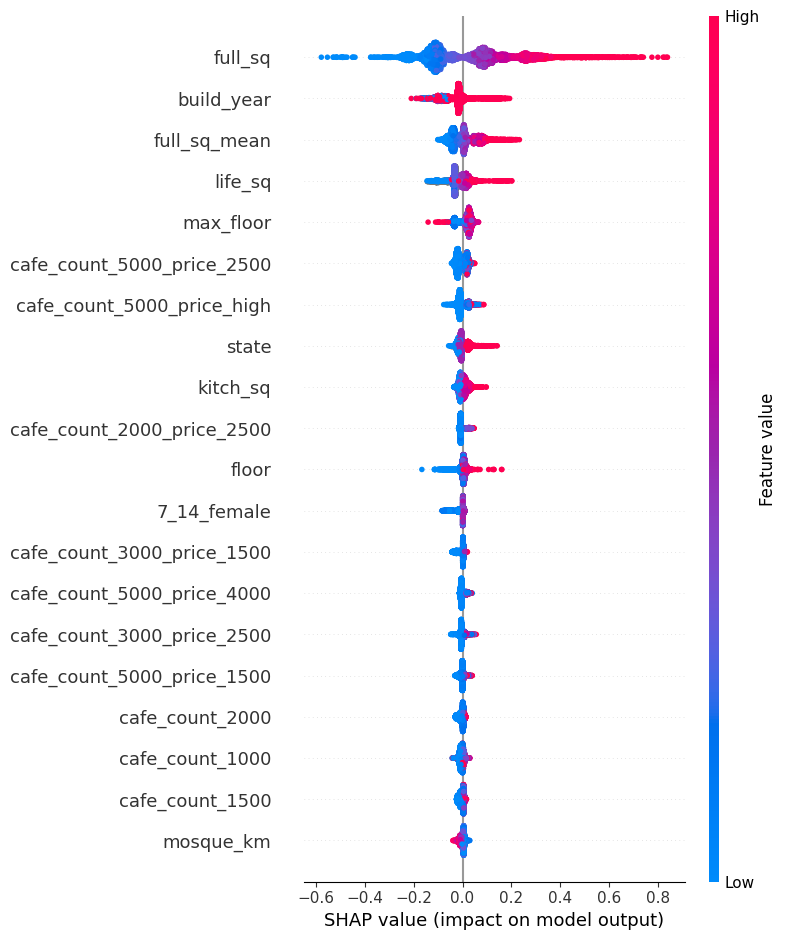

In [20]:
shap.summary_plot(shap_values, valid_x)

In [21]:
valid_x = x_test.drop(['timestamp','id'],axis=1)
explainer = shap.TreeExplainer(other_model)
%time shap_values = explainer.shap_values(valid_x)

CPU times: user 2min 15s, sys: 22 ms, total: 2min 15s
Wall time: 35.3 s


All-NaN slice encountered


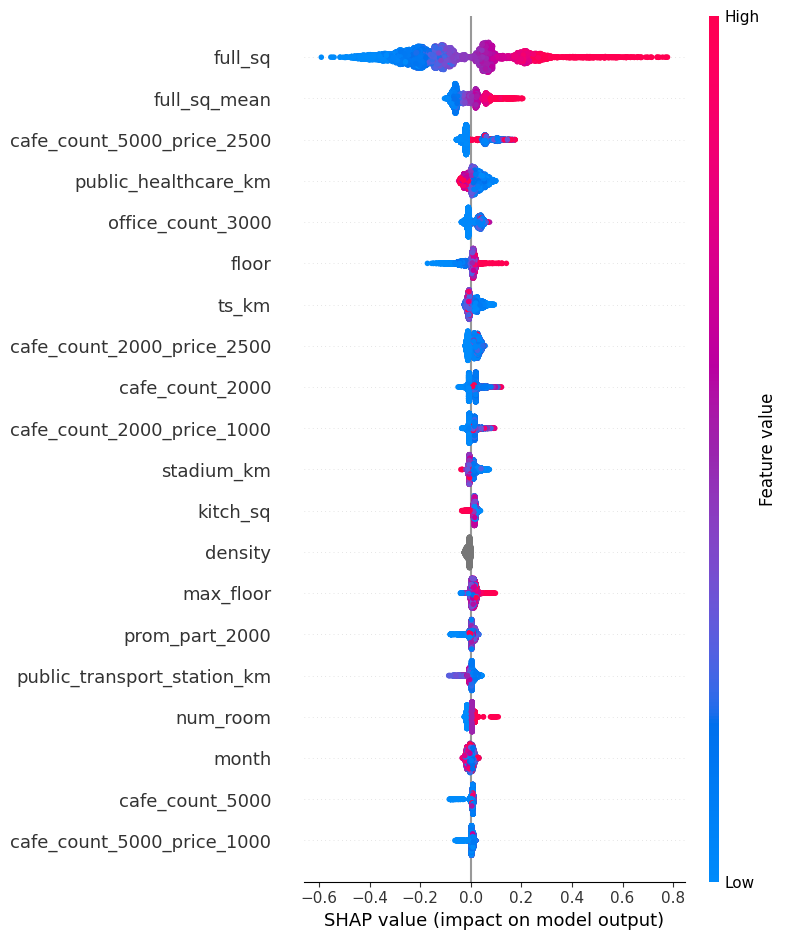

In [22]:
shap.summary_plot(shap_values, valid_x)